# Slopes for Simulated Videos

#### Everything should now be in order, run to find elasticity map for "test2percent" video.

In [1]:
#import functions

import numpy as np
from numpy import linalg

import cv2 as cv
import scipy
from scipy import signal

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl

import os
import shutil

from skimage.morphology import skeletonize
import skimage.io
from sklearn.mixture import GaussianMixture as GMM
from sklearn.linear_model import LinearRegression
from sklearn import mixture
from sklearn.cluster import DBSCAN

from functions import *
from wave_detection.line_detection_gmm import *

In [2]:
#cross correlation function

def cross_correlation (frNum, path_to_images, pixel, kernel, x_disp=False, y_disp=False):
    image_1_name = os.fsdecode(os.listdir(path_to_images)[0])
    image_1 = cv.imread(path_to_images + f'{image_1_name}', cv.IMREAD_GRAYSCALE)
    corr_full_x = np.zeros([image_1.shape[1], frNum])
    corr_full_y = np.zeros([image_1.shape[0], frNum])
    k=0
    while k<frNum:
        image_name = str(k) + '.jpg'
        image_next = cv.imread(path_to_images+f'{image_name}', cv.IMREAD_GRAYSCALE)
        if x_disp:
            arr_1 = np.ones([kernel,]) * image_1[pixel[0], pixel[1]]
            corr = signal.correlate(image_next[pixel[0], :], arr_1, mode='same')
            corr = np.reshape(cv.normalize(corr, None, 1, 256, cv.NORM_MINMAX), (image_1.shape[1],)) #normalization added
            corr_full_x[:, k] = corr
        if y_disp:
            arr_1 = np.ones([kernel,]) * image_1[pixel[0], pixel[1]]
            corr = signal.correlate(image_next[:, pixel[1]], np.transpose(arr_1), mode='same')
            corr = np.reshape(cv.normalize(corr, None, 1, 256, cv.NORM_MINMAX), (image_1.shape[0],)) #normalization added
            corr_full_y[:, k] = corr          
        k+=1
    
    return corr_full_x, corr_full_y


In [3]:
#DBScan clustering
class WaveDetector:
    def __init__(self, corr_image, peak_threshold=150):
    # def __init__(self, data_file, peak_threshold=30):    
        # self.correlation = np.genfromtxt(data_file, delimiter=',')
        self.correlation = corr_image

        self.n_pos = self.correlation.shape[0]
        self.n_time = self.correlation.shape[1]

        # Extract wave tip points with corresponding range of [0, 1] for position and time
        self.ind_siginificant = (self.correlation > peak_threshold)
        # self.ind_siginificant = (self.correlation < peak_threshold)

        # Step-size of 1 between position and time worked out to be optimal
        self.x_lim = [0, self.n_time]
        self.y_lim = [0, self.n_pos]
        
        time_vals, pos_vals = np.meshgrid(
            np.linspace(self.x_lim[0], self.x_lim[-1], self.n_time),
            np.linspace(self.y_lim[0], self.y_lim[-1], self.n_pos),
        )

        self.data = np.vstack((
            time_vals.flatten(),
            pos_vals.flatten(),
            # time_vals.flatten(),
        ))[:, self.ind_siginificant.flatten()]

        # self.data = self.data.T
        #self.do_dbscan()
        self.do_gmm_clustering()
    
    def do_dbscan(self, eps = 2, min_samples = 5, x_stretching = 1, do_plotting = False):
        self.temp_data = np.copy(self.data)
        self.temp_data[0,:] = self.data[0,:]*x_stretching
        self.dbscan = DBSCAN(eps = eps, min_samples = min_samples).fit(self.temp_data.T)
        self.unique_labels = set(self.dbscan.labels_)
        colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(self.unique_labels))]
        
        for k, col in zip(self.unique_labels, colors):
            if k == -1:
                # Black used for noise.
                col = [0, 0, 0, 1]

            class_member_mask = self.dbscan.labels_ == k

            xy = self.temp_data.T[class_member_mask]
            if do_plotting:
                plt.plot(
                    xy[:, 0],
                    xy[:, 1],
                    ".",
                    color=tuple(col),
                    markersize=14,
                    )
                plt.axis('equal')
            
    def do_linear_regression(self):
        reg_coeffs = []

        for label in self.unique_labels:
            if label == -1:
                continue

            class_member_mask = self.dbscan.labels_ == label

            xy = self.data.T[class_member_mask]
            reg = LinearRegression().fit(xy[:,0].reshape(-1, 1), xy[:,1].reshape(-1, 1))
            reg_coeffs.append(reg.coef_)

        return np.mean(reg_coeffs)

        
    def do_gmm_clustering(self, n_gmm=4):
        self.gmm = mixture.GaussianMixture(
            n_components=n_gmm,
            covariance_type="full",
            max_iter=100
        ).fit(self.data.T)
        
    


    def do_slope_estimation(self, rel_weight_margin=0.1, color='#ADD8E6', plot_results=False):
        # TODO: Pre-processing to remove ellipses which are in the upper left or bottom -> Done
        # self.count = []

        # for ii, mean in enumerate(self.gmm.means_):
        #     if mean[1] <= self.n_pos/2 and mean[0] <= self.n_time/3:
        #     # if mean[1] >= 80:
        #         self.count.append(ii)
        # self.gmm.means_ = np.delete(self.gmm.means_, self.count, 0)
        # self.gmm.covariances_ = np.delete(self.gmm.covariances_, self.count, 0)
        # self.gmm.weights_ = np.delete(self.gmm.weights_, self.count, 0)

        
        max_weight = np.max(self.gmm.weights_)

        if plot_results:
            # Plot only relevant clusters
            fig, ax = plt.subplots()

        self.slopes = []
        self.weights = []
        
        for ii, (mean, covar) in enumerate(zip(self.gmm.means_, self.gmm.covariances_)):
            # Neglect clusteres with only few points
            if self.gmm.weights_[ii] < rel_weight_margin * max_weight:
                continue
    
            # Eigen values are in ascending order -> last eigenvector is important!
            eig_vals, eig_vecs = linalg.eigh(covar)

            eig_vals = 2.0 * np.sqrt(2.0) * np.sqrt(eig_vals)
            uu = eig_vecs[0] / linalg.norm(eig_vecs[0])

            if any(eig_vecs[-1, :] < 1e-3):
                continue
            elif any(eig_vecs[-1, :] > 100):
                continue
            self.weights.append(self.gmm.weights_[ii])
            self.slopes.append(eig_vecs[-1, :] / linalg.norm(eig_vecs[-1, :]))
                    # self.slopes.append([-uu[1], uu[0]])

            if plot_results:
                        # Plot an ellipse to show the Gaussian component
                        angle = np.arctan2(uu[1], uu[0])
                        angle = 180.0 * angle / np.pi  # convert to degrees
                        ell = mpl.patches.Ellipse(mean, eig_vals[0], eig_vals[1], angle, color=color)
                        ell.set_clip_box(ax.bbox)
                        ell.set_alpha(0.5)
                        ax.add_artist(ell)
                
                # Get mean
            self.slopes = np.array(self.slopes).T

                # Check which slopes are pointing downwards
            ind_neg = (self.slopes[1, :] < 0)
            self.slopes[1, ind_neg] *= (-1)

                # Normalize weights
            self.weights = self.weights / np.sum(self.weights)
                
            self.mean_slope = np.sum(
                self.slopes * np.tile(self.weights, (self.slopes.shape[0], 1)), axis=1
                )

            slope = self.mean_slope[1] / self.mean_slope[0]

            if plot_results:
                    ax.scatter(self.data[0, :], self.data[1, :], color='k')
                    # ax.scatter([], [], color='k')
                    self.x_lim = ax.get_xlim()
                    self.y_lim = ax.get_ylim()

                    y1 = self.y_lim[0] + (self.x_lim[1] - self.x_lim[0]) * slope

                    ax.plot(self.x_lim, np.array([self.y_lim[0], y1]) + 0, '--', color='r',
                            linewidth=2, label=f"{round(slope, 6)} m / s")

                    ax.set_xlim(self.x_lim)
                    ax.set_ylim(self.y_lim)

                    ax.legend()

            return slope

    def plot_all_clusters(self, color='#ADD8B6'):
        fig, ax = plt.subplots()

        ax.scatter(self.data[0, :], self.data[1, :], color='k')
        
        for ii, (mean, covar) in enumerate(zip(self.gmm.means_, self.gmm.covariances_)):
            v, w = linalg.eigh(covar)
            v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
            u = w[0] / linalg.norm(w[0])
            
            # Plot an ellipse to show the Gaussian component
            angle = np.arctan(u[1] / u[0])
            angle = 180.0 * angle / np.pi  # convert to degrees
            ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(0.5)
            ax.add_artist(ell)

In [ ]:
#ONLY RUN ONCE
#making folders
os.mkdir('sim_2perc')
os.mkdir('sim_2perc_crop')

In [ ]:
#ONLY RUN ONCE
#extracting frames from the simulated 2 percent G1100 video
video_name = 'test2percent_G1100_cut'
path_to_source = 'data/' + video_name + '.avi'
cap = cv.VideoCapture(path_to_source)
num_frames = 50
l=0
m=0
while l <= num_frames:
    ret, frame = cap.read()
    if not ret: 
        print('No frames grabbed!')
        break
    cv.imwrite(f'sim_2perc/{m}.jpg', frame)
    l+=1
    m+=1

[ WARN:0@298877.560] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_5a1v4y7k9y/croot/opencv-suite_1676472757237/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@298877.560] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_5a1v4y7k9y/croot/opencv-suite_1676472757237/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_5a1v4y7k9y/croot/opencv-suite_1676472757237/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'




No frames grabbed!


In [ ]:
#ONLY RUN ONCE
# crop images for faster calculation 
data_path = 'sim_2perc/'
data_save = 'sim_2perc_crop/'
x_start = 50
x_end = 100
y_start = 5
y_end = 55
crop_images(data_path, data_save, x_start, x_end, y_start, y_end, color=False)

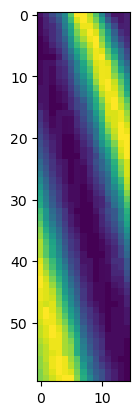

In [22]:
# implement slope measurement for one pixel
frNum = 15
path_to_images = 'sim_2perc_crop/'
kernel = 1
threshold_bin = 0
pixel = [0, 5]
_, corr_full_y = cross_correlation(frNum, path_to_images, pixel, kernel, x_disp=False, y_disp=True)

plt.imshow(corr_full_y)

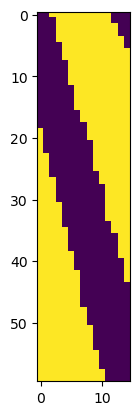

In [76]:
#clean version
T=50
image = np.copy(corr_full_y)
image[corr_full_y<T] = 0
image[corr_full_y>=T] = 1
plt.imshow(image)

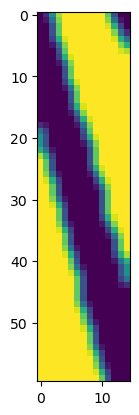

In [15]:
#blurred version
blur = cv.GaussianBlur(image, (3, 3), 0)
plt.imshow(blur)

In [77]:
blur_norm = cv.normalize(blur, None, 0, 255, cv.NORM_MINMAX)

/var/folders/f2/f6777kb92fl0_1l_4kqqrxqh0000gn/T/ipykernel_69926/991623920.py:182: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)


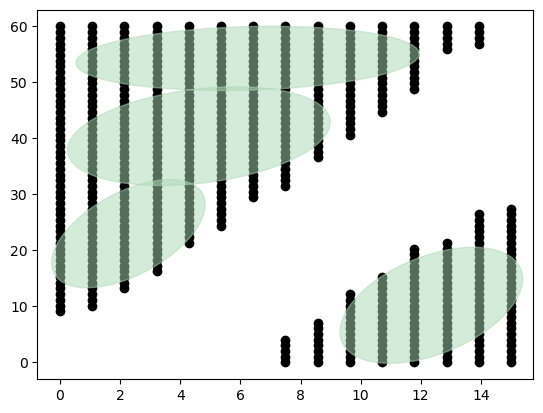

In [79]:
plt.close('all')
plt.ion()
my_detector = WaveDetector(corr_image=blur_norm)
my_detector.plot_all_clusters()


0.3894459457018012
0.4360184463437949


(-3.0, 63.0, -3.0, 63.0)

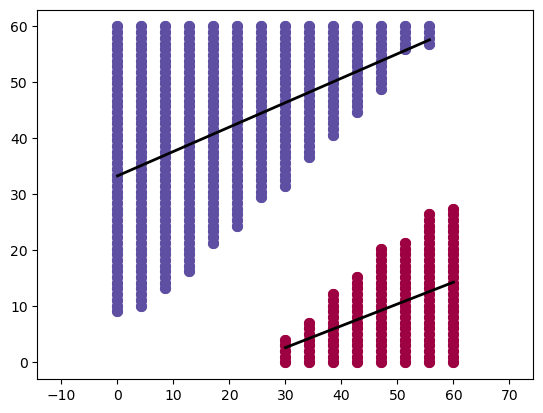

In [82]:
#using DBSCAN clustering method, groups lines by colour and plot lines of best fit 
my_detector.do_dbscan(eps =8, min_samples = 12, x_stretching = 4, do_plotting = True)
unique_labels = set(my_detector.dbscan.labels_)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = my_detector.dbscan.labels_ == k

    xy = my_detector.temp_data.T[class_member_mask]
    x_tuple = xy[:, 0],
    y_tuple = xy[:, 1],

    plt.plot(
        x_tuple,
        y_tuple,
        ".",
        color=tuple(col),
        markersize=14,

    )
    #reshape tuple into array so that it can be used in numpy expressions
    x_array=np.array(x_tuple).reshape(-1)
    y_array=np.array(y_tuple).reshape(-1)
    
    #find line of best fit
    line_slopes, b = np.polyfit(x_array, y_array, 1) 
    plt.plot(x_array, line_slopes*x_array+b, color='black', linestyle='-', linewidth=2)
    print(line_slopes)

plt.axis('equal') 



In [ ]:
# #linear regression attempt (leave for now)
# ax = sns.jointplot(x=x_array, y=y_array,
#               hue=None, color='#949ba4',
#               xlim=[-3,3], ylim=[-3,3], lw=0,
#               height=10, ratio=6
#              )
# for p in unique_labels:
#     sns.regplot(x=x_array, y=y_array,
#                 color='black', ax=ax.ax_joint)

# ax.ax_marg_x.remove()
# ax.ax_marg_y.remove()

# ax = sns.regplot(x=x_array, y=y_array,
#                  color='#949ba4', ax=ax.ax_joint, scatter=False, line_kws={'linestyle': '--'})

# sns.despine(ax=None, top=True, right=True, left=True,
#                  bottom=True, offset=None, trim=False)
#plt.show()

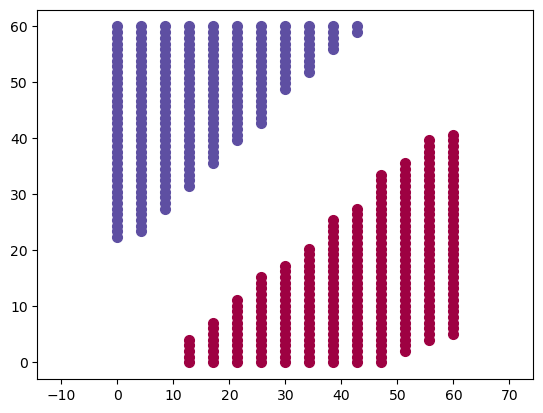

In [19]:
my_detector = WaveDetector(corr_image=blur_norm)
my_detector.do_dbscan(eps =8, min_samples = 12, x_stretching = 4, do_plotting = True)

In [88]:
reg_coeffs = []

for label in unique_labels:
    if k == -1:
        continue

    class_member_mask = my_detector.dbscan.labels_ == label

    xy = my_detector.data.T[class_member_mask]
    reg = LinearRegression().fit(xy[:,0].reshape(-1, 1), xy[:,1].reshape(-1, 1))
    reg_coeffs.append(reg.coef_)
    
np.mean(reg_coeffs)

1.6509287840911928

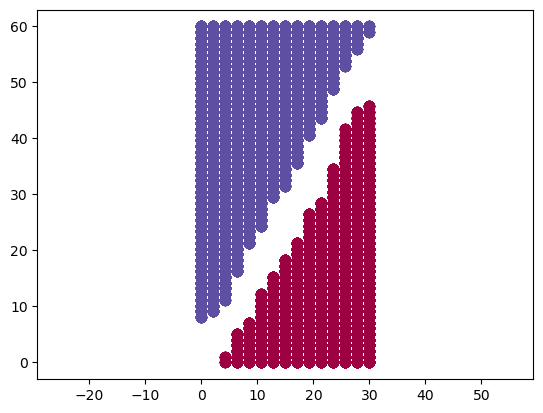

In [21]:
# Trying cropped simulated video (good video, 2 percent conc)

frNum = 15
path_to_images = 'sim_2perc_crop/'

kernel = 1
threshold_bin = 0
image_1 = cv.imread(path_to_images + '23.jpg', cv.IMREAD_GRAYSCALE)
slopes = np.zeros([image_1.shape[0], image_1.shape[1]])  # empty matrix of 50x50


for i in range(image_1.shape[0]):
    for j in range(image_1.shape[1]):
        pixel=[i, j]
        #print(pixel)
        try:
            _, corr_full_y = cross_correlation(frNum, path_to_images, pixel, kernel, x_disp=False, y_disp=True)
        
            T=50
            image = np.copy(corr_full_y)
            image[corr_full_y<T] = 0
            image[corr_full_y>=T] = 1
            blur = cv.GaussianBlur(image, (3, 3), 0)
            blur_norm = cv.normalize(blur, None, 0, 255, cv.NORM_MINMAX)
            my_detector = WaveDetector(corr_image=blur_norm)
            my_detector.do_dbscan(eps =5, min_samples = 10, x_stretching = 2, do_plotting = True)
            slope = my_detector.do_linear_regression()
        except ValueError:
            slope=None
        slopes[i, j] = slope

# #find line of best fit
# m, b = np.polyfit(corr_full_x, corr_full_y, 1) 
# plt.plot(corr_full_x, m*corr_full_x+b, color='black', linestyle='--', linewidth=2)



[[1.98456583 1.9711264  1.86108278 ... 1.62176467 1.61573029 1.65092878]
 [1.98456583 1.9711264  1.86108278 ... 1.62176467 1.61573029 1.65092878]
 [1.98456583 1.9711264  1.86108278 ... 1.62176467 1.61573029 1.65092878]
 ...
 [1.98456583 1.9711264  1.86108278 ... 1.62176467 1.61573029 1.65092878]
 [1.98456583 1.9711264  1.86108278 ... 1.62176467 1.61573029 1.65092878]
 [1.98456583 1.9711264  1.86108278 ... 1.62176467 1.61573029 0.43601845]]


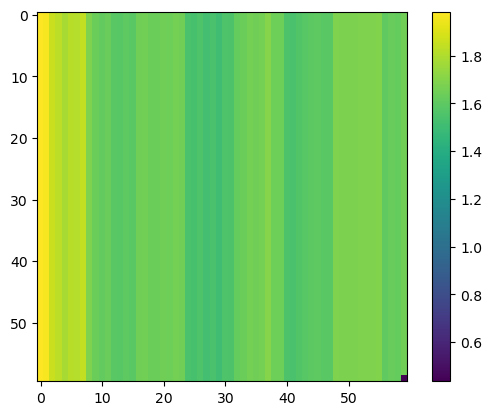

In [59]:
#plots slopes for in each pixel, colorbar used as legend
print(slopes)
plt.imshow(slopes)
plt.colorbar()


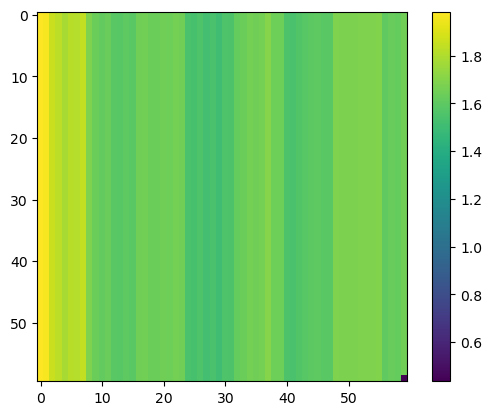

In [61]:
#making negative slopes positive, doesn't actually affect plot
new_slopes = slopes
for i in range(slopes.shape[0]):
    for j in range(slopes.shape[1]):
        if new_slopes[i,j]<0:
            new_slopes[i,j] *= -1
plt.imshow(new_slopes)
plt.colorbar()

In [62]:
# finding median slope (positive), not including nan values
nan_array = np.isnan(new_slopes)
not_nan_array = ~ nan_array
slope_notnan = new_slopes[not_nan_array]
replacement = np.median(slope_notnan)
replacement 

1.6383232505871859

In [63]:
#same value as above
for i in range(slopes.shape[0]):
    for j in range(slopes.shape[1]):
        if new_slopes[i,j]>100:
            new_slopes[i,j] = replacement
        elif np.isnan(new_slopes[i,j]):
            new_slopes[i,j] = replacement
new_slopes
median_of_slope_new = np.median(new_slopes)
median_of_slope_new

1.6383232505871859

In [64]:
# also same as above
nan_arrayN = np.isnan(new_slopes)
not_nan_arrayN = ~ nan_arrayN
slope_notnanN = new_slopes[not_nan_arrayN]
median_of_slope_new = np.median(slope_notnanN)
median_of_slope_new

1.6383232505871859

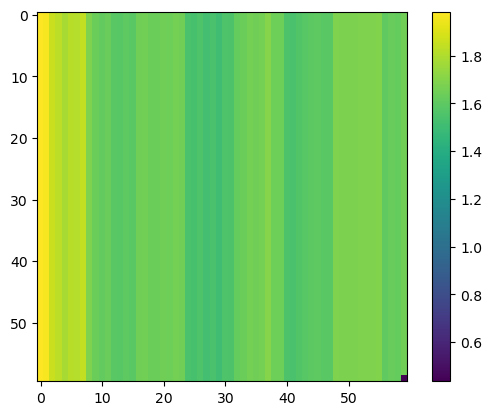

In [65]:
plt.imshow(new_slopes)
plt.colorbar()

In [66]:
# calculate elasticity
def elasticity_HT (slopes, dens, conv_pix, conv_fr):
    conv_factor = (conv_pix * conv_fr)
    mu = ((slopes * conv_factor)**2) * dens
    return mu

In [84]:
# Compute elasticity
dens = 1000
conv_pix = (1/2)*1e-6
conv_fr = 300000

mu = elasticity_HT(slopes, dens, conv_pix, conv_fr) ##THIS SHIT ISNT WORKING

In [85]:
# Get rid of nan values
nan_array = np.isnan(mu)
not_nan_array = ~ nan_array
mu_notnan = mu[not_nan_array]
np.median(mu_notnan)


60.39231915182767

In [86]:
#finding speed
speed = np.sqrt(mu_notnan/dens)
np.median(speed)

0.24574848758807788

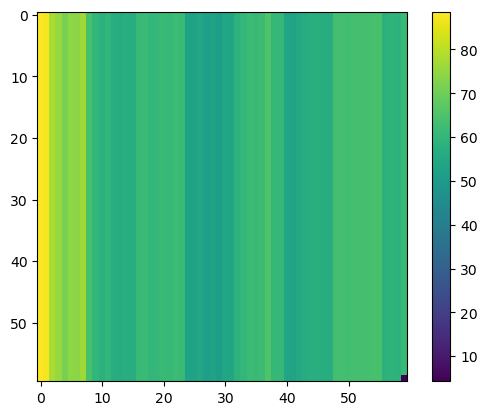

In [87]:
plt.imshow(mu)
plt.colorbar()